In [12]:
import h5py
import pandas as pd
from shapely.geometry import Polygon
from helper_functions import get_coords
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, AutoLocator
import matplotlib.colors as mcol
font = {'family' : 'serif',
         'size'   : 26,
         'serif':  'cmr10'
         }
plt.rc('font', **font)
plt.rc('axes', unicode_minus=False)
plt.rcParams.update({'font.size': 26})
pd.options.mode.chained_assignment = None

import pathlib
import platform
plt2 = platform.system()
if plt2 == 'Windows': pathlib.PosixPath = pathlib.WindowsPath

In [13]:
# aggregate_fittings = pd.read_hdf(
#     # "D:\Master\Granule-Explorer-Visualization-Tool\data\\aggregate_fittings_ml.h5", key="aggregate_data", mode="r"
#     # "D:\Master\Granule-Explorer-Visualization-Tool\data\\aggregate_fittings_ml.h5", key="fourier_terms", mode="r"
#     "D:\Master\Granule-Explorer-Visualization-Tool\data\\aggregate_fittings_ml.h5", key="fourier", mode="r"
# )
# aggregate_fittings['experiment'] = "ML_03_03_2024"
# aggregate_fittings.to_hdf("D:\Master\Granule-Explorer-Visualization-Tool\data\\aggregate_fittings_ml_renamed.h5", key="aggregate_data", mode="w")

# Compare fourier terms | IoU

In [14]:
fourier_pd_gradient = pd.read_hdf(
    # "D:/Granule_experiment_data/ALL_FOURIER_H5/2019-12-09_14.10.10--NCz--T1334--GFP_Burst.h5", key="fourier", mode="r" # id 2
    "D:\Master\Granule_Explorer\granule_explorer_core\experiments\gradient_new_version\old/2019-12-09_14.10.10--NCz--T1334--GFP_Burst.h5", key="fourier", mode="r" # id 2

    # "D:\Master\Granule_Explorer\granule_explorer_core\experiments/gradient_new_version/fourier/2020-02-05_14.43.03--NAs--T1354-GFP_Burst.h5", key="fourier", mode="r"
    
)
fourier_pd_ml = pd.read_hdf(
    "D:/Master/Granule_Explorer/granule_explorer_core/experiments/ML_method/old/2019-12-09_14.10.10--NCz--T1334--GFP_Burst.h5", key="fourier", mode="r"
    # "D:\Master\Granule_Explorer\granule_explorer_core\experiments\ML_method/fourier/2020-02-05_14.43.03--NAs--T1354-GFP_Burst.h5", key="fourier", mode="r"
)
fourier_pd_gradient_valid = fourier_pd_gradient[(fourier_pd_gradient['valid'] == True)]
fourier_pd_ml_valid = fourier_pd_ml[(fourier_pd_ml['valid'] == True)]

# fourier_pd_ml.iloc[302] # D:\Granule_experiment_data\ALL_FOURIER\2019-12-09_14.10.10--NCz--T1334--GFP_Burst.h5

## Amount of valid granules

In [15]:
nr_valid = fourier_pd_gradient['granule_id'].unique().size
print(f"Total granules (gradient) | {nr_valid}")

nr_valid_ml = fourier_pd_ml['granule_id'].unique().size
print(f"Total granules (ML)       | {nr_valid_ml}")

print("-----------")
nr_valid = fourier_pd_gradient_valid['granule_id'].unique().size
print(f"Valid granules (gradient) | {nr_valid}")

nr_valid_ml = fourier_pd_ml_valid['granule_id'].unique().size
print(f"Valid granules (ML)       | {nr_valid_ml}")
print("-----------")
print(f"ML has {nr_valid_ml-nr_valid} more valid granules than gradient method.")

Total granules (gradient) | 69
Total granules (ML)       | 69
-----------
Valid granules (gradient) | 62
Valid granules (ML)       | 55
-----------
ML has -7 more valid granules than gradient method.


In [16]:
# For all granule_id's
    # For each granule_id in frame
        # Calculate IoU

IoU = []
area_gradient_list = []
area_ml_list = []
granule_ids = []
frames = []

for frame_id in range(1000): # For all frames
    granules_in_gradient_frame = fourier_pd_gradient_valid[fourier_pd_gradient_valid['frame'] == frame_id]
    valid_granule_gradient_ids = granules_in_gradient_frame['granule_id'].unique() # All granules

    granules_in_frame_ml = fourier_pd_ml_valid[fourier_pd_ml_valid['frame'] == frame_id]
    # valid_granule_ids_ml = granules_in_frame_ml['granule_id'].unique() # All granules
    # print(valid_granule_ids)
    # print(valid_granule_ids_ml)
    # assert np.array_equal(valid_granule_ids, valid_granule_ids_ml), "Should always be equal"
    
    # Compare x,y positions to verify comparisons happen with correct granules, irrespective of their id's
    for granule_id in valid_granule_gradient_ids: # For all granules in frame
        
        granule_f_gradient_terms = granules_in_gradient_frame[granules_in_gradient_frame['granule_id'] == granule_id]

        granule_f_terms_ml = granules_in_frame_ml[granules_in_frame_ml['granule_id'] == granule_id]
        if granule_f_terms_ml.size == 0 :#or (granule_f_gradient_terms.iloc[0][['x','y']].tolist() != granule_f_terms_ml.iloc[0][['x','y']].tolist()):
            continue
        elif granule_f_terms_ml['mean_radius'].iloc[0] == 0 or granule_f_gradient_terms['mean_radius'].iloc[0] == 0:
            continue

        xs, ys = get_coords(granule_f_gradient_terms, get_relative=True)
        xy = np.vstack((xs,ys)).T
        area_gradient = Polygon(xy)


        # if (granule_f_gradient_terms.iloc[0][['x','y']].tolist() == granule_f_terms_ml.iloc[0][['x','y']].tolist()):
        xs_ml, ys_ml = get_coords(granule_f_terms_ml, get_relative=True) 
        xy = np.vstack((xs_ml,ys_ml)).T 
        area_ml = Polygon(xy) 
        if not area_gradient.is_valid or not area_ml.is_valid:
            print("Invalid")
            continue 
        intersection = area_gradient.intersection(area_ml).area / area_gradient.union(area_ml).area

        IoU.append(intersection)
        area_gradient_list.append(area_gradient.area)
        area_ml_list.append(area_ml.area)
        granule_ids.append(granule_f_gradient_terms.iloc[0]['granule_id'])
        frames.append(granule_f_gradient_terms.iloc[0]['frame'])
    #     if intersection < 0.68:
    #         print(f"Area {area_gradient.area} | Area_ml {area_ml.area} | IoU: {intersection} | Same Position: {granule_f_gradient_terms.iloc[0][['x','y']].tolist() == granule_f_terms_ml.iloc[0][['x','y']].tolist()}")
    #         fig = px.scatter(x=xs, y=ys)
    #         fig.add_trace(go.Scatter(x=xs, y=ys, marker=dict(color='red', size=16), name=f"100 p border {id}"))
    #         fig.add_trace(go.Scatter(x=xs_ml, y=ys_ml, marker=dict(color='yellow', size=16), name=f"100 p border {id}"))
    #         # fig.add_trace(go.Scatter(x=xs_ml, y=ys_ml, marker=dict(color='blue', size=2), mode="markers", name=f"100 p border {id}"))
    #         fig.show()
    #     break
    # break
    
df = pd.DataFrame({
    "area_gradient":area_gradient_list,
    "area_ml":area_ml_list,
    "IoU":IoU,
    "granule_ids": granule_ids,
    "frames": frames
})

Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid
Invalid


In [17]:
df[df['IoU'] < 0.67]

,area_gradient,area_ml,IoU,granule_ids,frames
5,100.972908,112.119631,0.660419,6,0
7,64.838766,76.952009,0.609922,13,0
8,67.216954,76.745117,0.644133,14,0
10,56.128730,70.515380,0.492380,18,0
11,57.393094,75.503027,0.503828,19,0
...,...,...,...,...,...
3895,67.818689,78.032105,0.648938,5,994
3898,66.847255,75.188910,0.659424,2,995
3900,76.926492,89.924582,0.633644,4,996
3904,69.133792,80.835761,0.649892,5,997


In [18]:
mean_IoU = df['IoU'].mean()
print(mean_IoU)
IoU_std = df['IoU'].std()
print(IoU_std)


0.7404846227046701
0.12712653108161934


Previous:

0.9196691274162706 <br>
0.05097715592981259

Small improvement in mean IoU (+0.01) and std (-0.01)

In [19]:
# fig = px.violin(df["IoU"], y="IoU", title="IoU distribution", box=True, points="all")
# fig.show()

fig = px.histogram(x=df["IoU"],
                   marginal="box", # or violin, rug
                   nbins=100)
                #    hover_data=stats_df["1"].columns, nbins=50)
fig.update_layout(
    xaxis_title="IoU", yaxis_title="Count"
)
fig.update_layout(width=1200, height=500, showlegend=False, font_size=20)
fig.write_image(file="D:/Master/MasterProject/Overleaf_figures/Chapter5/Granule_IoU_dist.svg", )#height=1000, width=1000)
fig.show()

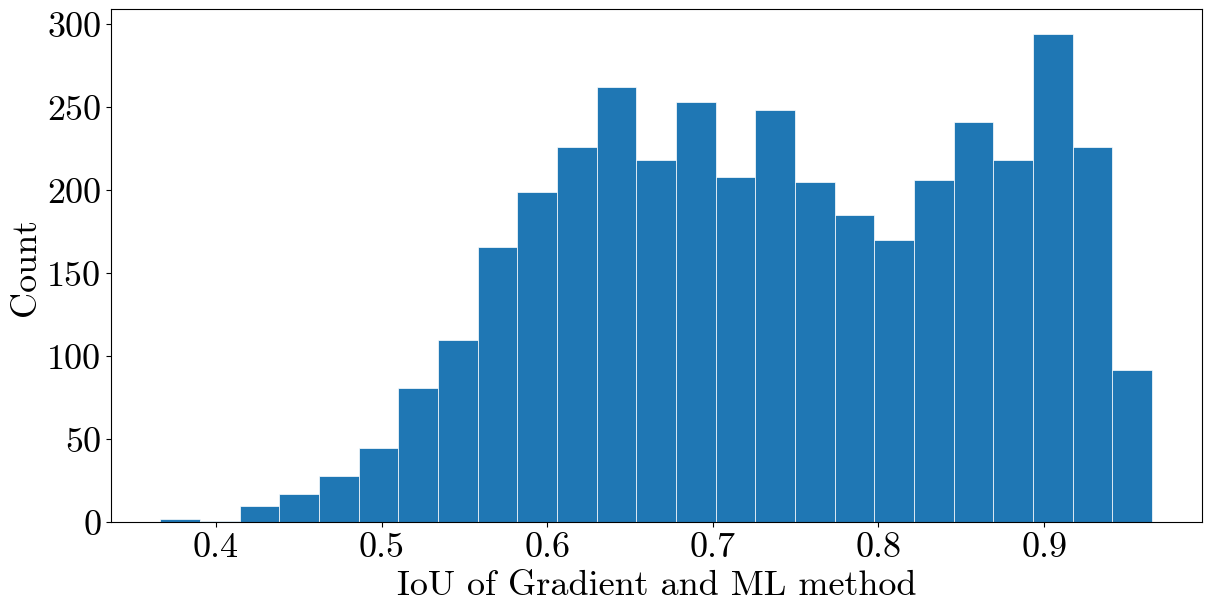

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6), layout='constrained')
# --- Hist ---
ax.hist(df["IoU"], bins=25, linewidth=0.5, edgecolor="white")
ax.set_ylabel('Count')
ax.set_xlabel('IoU of Gradient and ML method')
fig.savefig("D:/Master/MasterProject/Overleaf_figures/Chapter5/5.2/Granule_IoU_dist.svg")   

Old distribution:

Make a histogram comparing the area of the ML and gradient. If it skews we have a bias towards making bigger/smaller granules in the model.

ML on y axis, Gradient on x axis. Each point is is the area of the graunle for each method.

In [21]:
# df['name'] = 'Id: '+df['granule_ids'].astype(str) + ' Frame: ' + df['frames'].astype(str)
df

,area_gradient,area_ml,IoU,granule_ids,frames
0,197.815915,193.893138,0.927910,0,0
1,159.083949,158.521543,0.888531,1,0
2,152.089876,150.164359,0.890901,2,0
3,113.693099,115.408687,0.817095,4,0
4,109.169076,108.839394,0.846706,5,0
...,...,...,...,...,...
3906,148.707641,149.417892,0.907630,0,998
3907,79.160904,93.976755,0.683013,4,998
3908,149.231261,149.785370,0.944926,0,999
3909,78.769681,90.764127,0.696330,4,999


In [22]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['area_gradient'], y=df['area_ml'], mode='markers', 
                        customdata=df,  
                        hovertemplate=
                            "<b>Frame %{customdata[4]}</b><br>" +
                            "<b>id %{customdata[3]}</b><br>" +
                            "IoU: %{customdata[2]:.3f}<br>" +
                            "Gradient Area: %{customdata[0]:.2f}<br>" +
                            "ML Area: %{customdata[1]:.2f}<br>" +
                            "<extra></extra>",
                         
                         ))#'Granules'))
fig.add_trace(go.Scatter(x=[0,650], y=[0,650], name="Perfect match", opacity=0.7))
fig.update_layout(
    # title="ML area vs Gradient area",
    xaxis_title="Gradient Area",
    yaxis_title="ML Area",
    # legend_title="Area",
)
fig.update_layout(width=1200, height=500, showlegend=False, font_size=20)
fig.write_image(file="D:/Master/MasterProject/Overleaf_figures/Chapter5/ML_Gradient_comparison.svg", )#height=1000, width=1000)
fig.show()

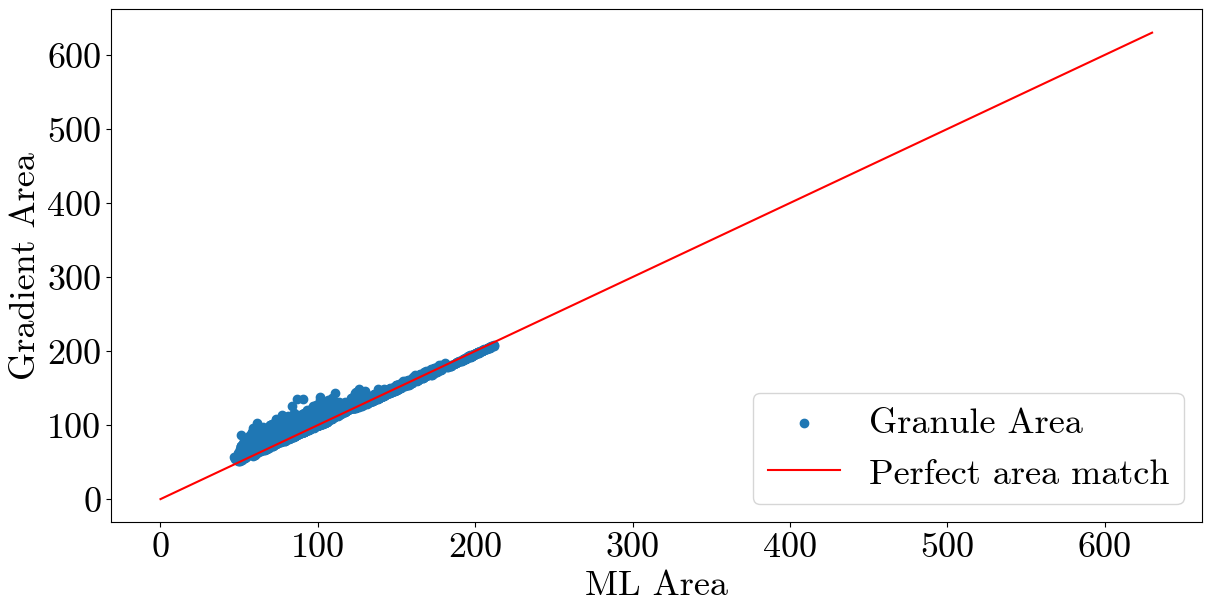

In [23]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 6), layout='constrained')
ax1.scatter(df['area_gradient'], df['area_ml'], label=f"Granule Area", ) #, 'o', ls='-', ms=4)
ax1.set_xlabel('ML Area')
ax1.set_ylabel('Gradient Area')

ax1.plot([0,630], [0, 630], label=f"Perfect area match", c='red')
ax1.legend(loc='lower right')
fig.savefig("D:/Master/MasterProject/Overleaf_figures/Chapter5/5.2/ML_Gradient_comparison.svg", )#height=1000, width=1000)

# Plot 

In [24]:
frame = 856
g_id = 425

frame = 8
g_id = 4

granules_in_gradient_frame = fourier_pd_gradient_valid[fourier_pd_gradient_valid['frame'] == frame]
granules_in_frame_ml = fourier_pd_ml_valid[fourier_pd_ml_valid['frame'] == frame]

granule_f_gradient_terms = granules_in_gradient_frame[granules_in_gradient_frame['granule_id'] == g_id]
granule_f_terms_ml = granules_in_frame_ml[granules_in_frame_ml['granule_id'] == g_id]

xs, ys = get_coords(granule_f_gradient_terms, get_relative=True)
xy = np.vstack((xs,ys)).T
area_gradient = Polygon(xy)
xs_ml, ys_ml = get_coords(granule_f_terms_ml, get_relative=True) 
xy = np.vstack((xs_ml,ys_ml)).T 
area_ml = Polygon(xy) 

intersection = area_gradient.intersection(area_ml).area / area_gradient.union(area_ml).area

print(f"Area_g {area_gradient.area} | Area_ml {area_ml.area} | IoU: {intersection} | Same Position: {granule_f_gradient_terms.iloc[0][['x','y']].tolist() == granule_f_terms_ml.iloc[0][['x','y']].tolist()}")
fig = px.scatter(x=xs, y=ys, title=f"Frame {frame} granule {g_id}")
fig.add_trace(go.Scatter(x=xs, y=ys, marker=dict(color='red', size=16), name=f"Gradient"))
fig.add_trace(go.Scatter(x=xs_ml, y=ys_ml, marker=dict(color='yellow', size=16), name=f"ML"))
# fig.add_trace(go.Scatter(x=xs_ml, y=ys_ml, marker=dict(color='blue', size=2), mode="markers", name=f"100 p border {id}"))
fig.show()

Area_g 105.07814485739574 | Area_ml 106.19214616004653 | IoU: 0.8631310544012677 | Same Position: True


# Interfacial tension error intervals

In [25]:
aggregate_fittings_gradient = pd.read_hdf(
    # "C:/Users/Endre/Desktop/Granule-Explorer-Visualization-Tool/data/aggregate_fittings_gradient.h5", key="aggregate_data", mode="r" # This one
    "D:\Master\Granule_Explorer\granule_explorer_core\experiments\gradient_new_version\old/aggregate_fittings.h5", key="aggregate_data", mode="r" 

    # "D:\Master\Granule-Explorer-Visualization-Tool\data\\aggregate_fittings_gradient.h5", key="aggregate_data", mode="r"
    # "D:\Master\Granule-Explorer-Visualization-Tool\data\\aggregate_fittings_ml.h5", key="fourier_terms", mode="r"
)

aggregate_fittings_ml = pd.read_hdf(
    # "C:/Users/Endre/Desktop/Granule-Explorer-Visualization-Tool/data/aggregate_fittings_ML_FIXED.h5", key="aggregate_data", mode="r" # This one
    "D:\Master\Granule_Explorer\granule_explorer_core\experiments\ML_method\old/aggregate_fittings.h5", key="aggregate_data", mode="r"
)
# aggregate_fittings_ml['experiment'] = "ML_03_03_2024"
print("ML granules", aggregate_fittings_ml.shape)
print("Gradient granules", aggregate_fittings_gradient.shape)

ML granules (67, 24)
Gradient granules (151, 24)


### Filter unwanted granules

In [26]:
aggregate_fittings_gradient = aggregate_fittings_gradient.query("sigma > 1e-10 and pass_rate > 0.6 and fitting_error < 0.6 and fitting_diff > 0.03")
aggregate_fittings_ml = aggregate_fittings_ml.query("sigma > 1e-10 and pass_rate > 0.6 and fitting_error < 0.6 and fitting_diff > 0.03")

In [27]:
print("ML granules", aggregate_fittings_ml.shape)
print("Gradient granules", aggregate_fittings_gradient.shape)

ML granules (8, 24)
Gradient granules (31, 24)


Try different filter, see which one has impact. One of the filters might have a larger impact then the others. It could be useful to know which and what properties it has. 

Previous:

ML granules (56, 23) <br>
Gradient granules (51, 23)

Improvement: +22

Thought: Model is trained on data that passes the valid filter. Model wants to emulate this -> Has a bias towards placing points which pass the filters.

In [28]:
print("Gradient ids", aggregate_fittings_gradient['granule_id'].tolist())
print("ML ids      ", aggregate_fittings_ml['granule_id'].to_list())

Gradient ids [0, 1, 2, 4, 5, 12, 15, 18, 31, 35, 40, 50, 52, 2, 9, 10, 14, 18, 19, 22, 27, 32, 37, 41, 43, 55, 56, 71, 73, 78, 79]
ML ids       [0, 4, 5, 14, 19, 35, 0, 2]


### Check if equal position and id's 

In [29]:
# (all((aggregate_fittings_ml['granule_id'] == aggregate_fittings_gradient['granule_id'])) and 
#  all((aggregate_fittings_ml['x'] == aggregate_fittings_gradient['x'])) and 
#  all((aggregate_fittings_ml['y'] == aggregate_fittings_gradient['y']))) 

In [30]:
aggregate_merge = pd.merge(aggregate_fittings_gradient, aggregate_fittings_ml, how='inner', on=['granule_id'])
print("Granules in common", aggregate_merge.shape[0])

Granules in common 9


Previous:

Granules in common 20

Have a look at the common 29 and the other ones. Visualize them, see if we can find a difference. What is it about the other granules that are not the same.

### Gradient_Sigma in range of ML Sigma

In [31]:
lower = aggregate_merge['sigma_y'] - aggregate_merge['sigma_err_y']
higher = aggregate_merge['sigma_y'] + aggregate_merge['sigma_err_y']
# (lower <= aggregate_fittings_gradient['sigma']) == (aggregate_fittings_gradient['sigma'] <= higher)
aggregate_merge['gradient_sigma_in_range_ml'] = (lower <= aggregate_merge['sigma_x']) & (aggregate_merge['sigma_x'] <= higher)

### ML_Sigma in range of Gradient_Sigma

In [32]:
lower = aggregate_merge['sigma_x'] - aggregate_merge['sigma_err_x']
higher = aggregate_merge['sigma_x'] + aggregate_merge['sigma_err_x']
# (lower <= aggregate_fittings_gradient['sigma']) == (aggregate_fittings_gradient['sigma'] <= higher)
aggregate_merge['ml_sigma_in_range_gradient'] = (lower <= aggregate_merge['sigma_y']) & (aggregate_merge['sigma_y'] <= higher)

In [33]:
# aggregate_merge[['sigma', 'sigma_err', 'gradient_sigma_in_range_ml', 'ml_sigma_in_range_gradient']]
aggregate_merge[['gradient_sigma_in_range_ml']].value_counts()

gradient_sigma_in_range_ml
False                         6
True                          3
Name: count, dtype: int64

Previous:

False                         11 <br>
True                           9

In [34]:
aggregate_merge[['ml_sigma_in_range_gradient']].value_counts()

ml_sigma_in_range_gradient
False                         5
True                          4
Name: count, dtype: int64

Previous:

True                          12 <br>
False                          8

In [35]:
aggregate_merge['sigma_in_both_ranges'] = (aggregate_merge['ml_sigma_in_range_gradient'] & aggregate_merge['gradient_sigma_in_range_ml'])
aggregate_merge['sigma_in_both_ranges'].value_counts()

sigma_in_both_ranges
False    8
True     1
Name: count, dtype: int64

Previous

False    11 <br>
True      9

In [36]:
aggregate_merge.rename(columns={'sigma_x':'sigma_gradient', 'sigma_err_x':'sigma_err_gradient','sigma_y':'sigma_ml', 'sigma_err_y':'sigma_err_ml'}, inplace=True)
# cols = ['granule_id', 'sigma_ml', 'sigma_err_ml', 'gradient_sigma_in_range_ml', 'ml_sigma_in_range_gradient', 'sigma_in_both_ranges']
combined_df = aggregate_merge[['granule_id', 'sigma_ml', 'sigma_err_ml', 'sigma_gradient', 'sigma_err_gradient', 'gradient_sigma_in_range_ml', 'ml_sigma_in_range_gradient', 'sigma_in_both_ranges']]

# Calc std distance between ML to gradient relative to gradient
combined_df['std_sigma_distance'] = (combined_df['sigma_ml'] - combined_df['sigma_gradient']) / combined_df['sigma_err_gradient']

combined_df.to_csv("Sigma_in_range.csv")
combined_df

,granule_id,sigma_ml,sigma_err_ml,sigma_gradient,sigma_err_gradient,gradient_sigma_in_range_ml,ml_sigma_in_range_gradient,sigma_in_both_ranges,std_sigma_distance
0,0,6.878583e-08,2.220719e-08,2.196888e-07,6.831746e-08,False,False,False,-2.208849
1,0,8.557699e-08,4.017859e-08,2.196888e-07,6.831746e-08,False,False,False,-1.963068
2,2,2.059722e-07,2.805041e-07,3.388513e-07,3.692741e-08,True,False,False,-3.598387
3,2,2.059722e-07,2.805041e-07,4.862164e-07,1.737527e-07,True,False,False,-1.612891
4,4,1.961857e-08,2.538077e-08,8.545812e-08,1.028545e-07,False,True,False,-0.640123
5,5,1.180132e-08,4.512403e-08,1.800281e-08,2.586279e-07,True,True,True,-0.023978
6,35,5.281718e-08,2.034197e-08,7.653785e-08,5.631680e-08,False,True,False,-0.421201
7,14,1.269517e-07,1.298972e-07,7.904382e-07,3.839644e-07,False,False,False,-1.727990
8,19,8.571314e-09,2.541614e-08,6.219124e-08,1.118243e-07,False,True,False,-0.479502


In [37]:
combined_df['std_sigma_distance'].abs().mean()

1.4084431895220488

Plot std divation of the ML from the gradient one. Sigma_x - Sigma_y / std_of_gradient (sigma_err_gradient)

For each row, calculate how many standard deviations away the ML results are from the gradient method.

In [38]:
# For all granule_id's
    # For each granule_id in frame
        # Calculate IoU

# for frame_id in range(1000): # For all frames
#     granules_in_gradient_frame = fourier_pd_gradient_valid[fourier_pd_gradient_valid['frame'] == frame_id]
#     valid_granule_gradient_ids = granules_in_gradient_frame['granule_id'].unique() # All granules

#     granules_in_frame_ml = fourier_pd_ml_valid[fourier_pd_ml_valid['frame'] == frame_id]
#     valid_granule_ids_ml = granules_in_frame_ml['granule_id'].unique() # All granules

#     # Compare x,y positions to verify comparisons happen with correct granules, irrespective of their id's
#     for granule_id in valid_granule_gradient_ids: # For all granules in frame
        

#         granule_f_gradient_terms = granules_in_gradient_frame[granules_in_gradient_frame['granule_id'] == granule_id]
    

#         granule_f_terms_ml = granules_in_frame_ml[granules_in_frame_ml['granule_id'] == granule_id]
#         if granule_f_terms_ml.size == 0:
#             continue
#         if (granule_f_gradient_terms.iloc[0][['x','y']].tolist() == granule_f_terms_ml.iloc[0][['x','y']].tolist()):
#             # raise Exception("wah")
#             pass
#             break
#     break
    
    

# Plot std of ML to Gradient method

In [39]:
combined_df['both_in_range_color'] = ['green' if x else 'red' for x in combined_df['sigma_in_both_ranges']] 

fig = go.Figure()
fig.add_trace(go.Scatter(x=combined_df['std_sigma_distance'],
                    mode='markers',
                    name='markers',
                    marker=dict(
                        #size=16,
                        color = combined_df['both_in_range_color'], #set color equal to a variable
                    ),
                    # customdata=df1[['count']],
                    # hovertemplate=
                    #     "<b>Amount %{customdata[0]}</b><br><br>" +
                    #     "Width %{x}<br>" +
                    #     "Height: %{y}<br>" +
                    #     "<extra></extra>",
                    
    ))
fig.update_layout(
        xaxis_title=dict(text='std away from gradient', font=dict(size=20)),
        yaxis_title=dict(text='', font=dict(size=20)),
)
fig.update_layout(
    {
        # xaxis=dict(tickfont=dict(size=14, color='#FFFFFF')),
        # yaxis=dict(tickfont=dict(size=14, color='#FFFFFF')),

        "paper_bgcolor": "rgba(0, 0, 0, 0)",
        # "plot_bgcolor": "rgba(0, 0, 0, 0)",
    }
)
fig.update_layout(font_size=20)
fig.write_image(file="D:/Master/MasterProject/Overleaf_figures/Chapter5/ML_gradient_stf_both_in_range.svg", height=600, width=1200)
fig.show()

In [40]:
# cmap = mcol.ListedColormap(["green","red"])
# cmap
# bounds = [-0.5, 0.5]
# norm = mcol.BoundaryNorm(bounds, cmap.N)
# norm
# colors: np.array = np.where(combined_df['sigma_in_both_ranges'], [255, 0, 0], [0, 255, 0]) # 'green': (195, 255, 104, 1) , 'red': (255, 99, 71, 1)
import matplotlib
colors = matplotlib.colors.to_rgba_array(["g", "r"])

combined_df['both_in_range_color'] = [colors[0] if x else colors[1] for x in combined_df['sigma_in_both_ranges']] 
combined_df['both_in_range_color'].to_list()


[array([1., 0., 0., 1.]),
 array([1., 0., 0., 1.]),
 array([1., 0., 0., 1.]),
 array([1., 0., 0., 1.]),
 array([1., 0., 0., 1.]),
 array([0. , 0.5, 0. , 1. ]),
 array([1., 0., 0., 1.]),
 array([1., 0., 0., 1.]),
 array([1., 0., 0., 1.])]

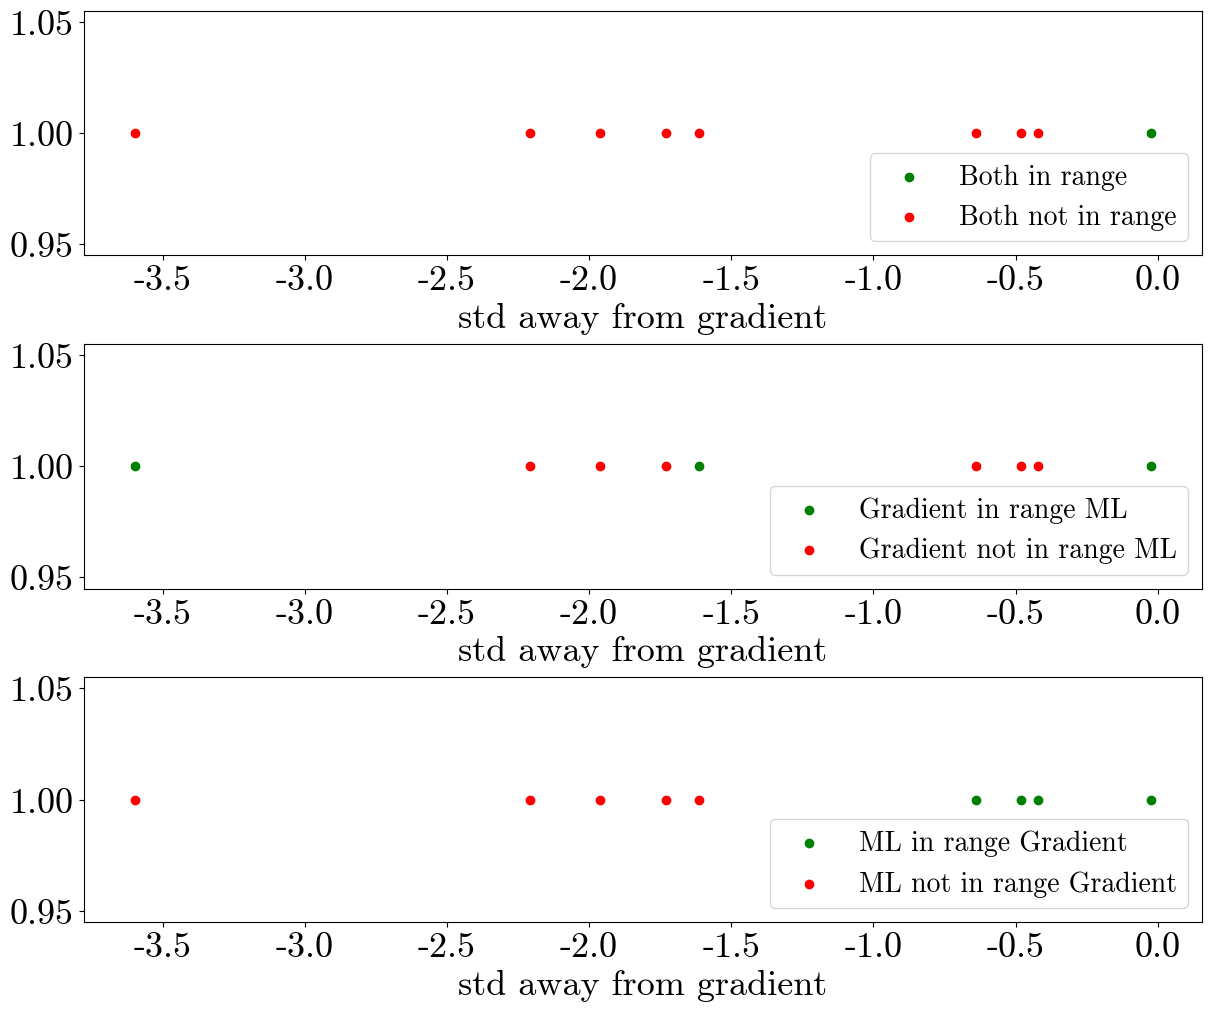

In [41]:
combined_df['both_in_range_color'] = [colors[0] if x else colors[1] for x in combined_df['sigma_in_both_ranges']] 
combined_df['gradient_in_range_color'] = [colors[0] if x else colors[1] for x in combined_df['gradient_sigma_in_range_ml']] 
combined_df['ML_in_range_color'] = [colors[0] if x else colors[1] for x in combined_df['ml_sigma_in_range_gradient']] 


fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, ncols=1, figsize=(12, 10), layout='constrained')

for t in [True, False]:
    if t:
        color = 'g'
    else:
        color = 'r'
    
    copy_df = combined_df.copy(deep=True)

    label = "Both in range" if t else "Both not in range"
    ax1.scatter(copy_df[copy_df['sigma_in_both_ranges'] == t]['std_sigma_distance'], list(1 for _ in range(len(copy_df[copy_df['sigma_in_both_ranges'] == t]['std_sigma_distance']))), 
                c=color, label=label) #, 'o', ls='-', ms=4)
    # ax1.set_ylabel('Max error (%)')
    ax1.set_xlabel('std away from gradient')
    ax1.legend(loc='lower right', prop={'size': 20})

    label = "Gradient in range ML" if t else "Gradient not in range ML"
    ax2.scatter(copy_df[copy_df['gradient_sigma_in_range_ml'] == t]['std_sigma_distance'], list(1 for _ in range(len(copy_df[copy_df['gradient_sigma_in_range_ml'] == t]['gradient_sigma_in_range_ml']))), 
                c=color, label=label, ) #, 'o', ls='-', ms=4)
    # ax2.set_ylabel('Max error (%)')
    ax2.set_xlabel('std away from gradient')
    ax2.legend(loc='lower right', prop={'size': 20})

    label = "ML in range Gradient" if t else "ML not in range Gradient"
    ax3.scatter(copy_df[copy_df['ml_sigma_in_range_gradient'] == t]['std_sigma_distance'], list(1 for _ in range(len(copy_df[copy_df['ml_sigma_in_range_gradient'] == t]['ml_sigma_in_range_gradient']))), 
                c=color, label=label, ) #, 'o', ls='-', ms=4)
    # ax3.set_ylabel('Max error (%)')
    ax3.set_xlabel('std away from gradient')
    ax3.legend(loc='lower right',  prop={'size': 20})

# fig.show()
# fig.savefig("D:/Master/MasterProject/Overleaf_figures/Chapter4/scaling_error.svg")

# X = [ 1, 2]
# Y = [ 1, 2]
# C = np.array([[255, 0, 0], [0, 255, 0]])
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.scatter(X, Y, c = C/255.0)
# plt.show()

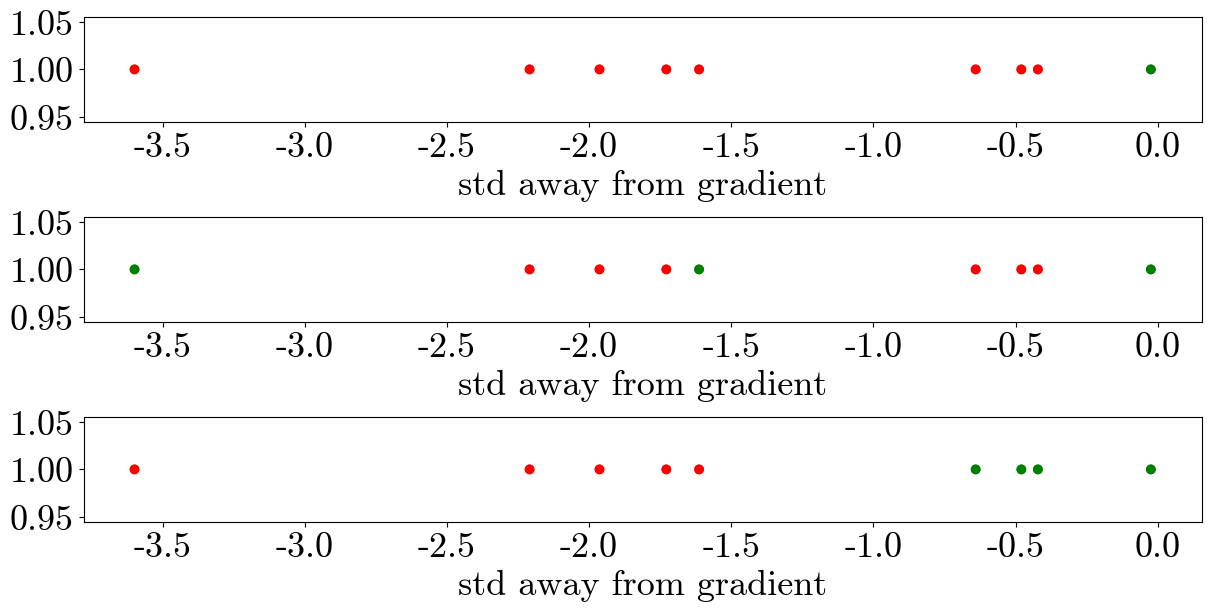

In [42]:
combined_df['both_in_range_color'] = [colors[0] if x else colors[1] for x in combined_df['sigma_in_both_ranges']] 
combined_df['gradient_in_range_color'] = [colors[0] if x else colors[1] for x in combined_df['gradient_sigma_in_range_ml']] 
combined_df['ML_in_range_color'] = [colors[0] if x else colors[1] for x in combined_df['ml_sigma_in_range_gradient']] 


fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, ncols=1, figsize=(12, 6), layout='constrained')

for t in [True, False]:
    ax1.scatter(combined_df['std_sigma_distance'], list(1 for _ in range(len(combined_df['std_sigma_distance']))), c=combined_df['both_in_range_color'].to_list(), label=f"", ) #, 'o', ls='-', ms=4)
    # ax1.set_ylabel('Max error (%)')
    ax1.set_xlabel('std away from gradient')

    ax2.scatter(combined_df['std_sigma_distance'], list(1 for _ in range(len(combined_df['gradient_sigma_in_range_ml']))), c=combined_df['gradient_in_range_color'].to_list(), label=f"", ) #, 'o', ls='-', ms=4)
    # ax2.set_ylabel('Max error (%)')
    ax2.set_xlabel('std away from gradient')

    ax3.scatter(combined_df['std_sigma_distance'], list(1 for _ in range(len(combined_df['ml_sigma_in_range_gradient']))), c=combined_df['ML_in_range_color'].to_list(), label=f"", ) #, 'o', ls='-', ms=4)
    # ax3.set_ylabel('Max error (%)')
    ax3.set_xlabel('std away from gradient')

# fig.show()
# fig.savefig("D:/Master/MasterProject/Overleaf_figures/Chapter4/scaling_error.svg")

# X = [ 1, 2]
# Y = [ 1, 2]
# C = np.array([[255, 0, 0], [0, 255, 0]])
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.scatter(X, Y, c = C/255.0)
# plt.show()

# Observations
Valid granules in both fourier.h5 from the same .ims experiment.

grandient -        [ 1  2  5  7  8 10 11 12 16 17 18 19 20 22 24 25 26 28 31 32] <br>
Machine learning - [ 1  2  5  6  7  8  9 10 11 12 16 17 18 19 21 22 24 25 26 27 28 29 30 31 32 34]

## Questions

1. Are granule id's the same irrespective of boundry extraction method? (I think so, but double check)


Dataset is only based on one experiment, include 'insert name here' to better represent the granule population.
Located in 2020-02-05 (Arsinite) and 2019-10-31 (Arsenite) and 2019-12-09 (Clotrimazole)

/export/grellscheidfs/granule_explorer/experiments/jan_reRun_C


Ask Pekka: When is the defence/presentation, how to find/pick a sensor?